In [56]:
# Imports
from datetime import timedelta, date, datetime

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [130]:
# Reading the data
daily_df = pd.read_csv('data/clean_data/daily.csv').set_index('id')
daily_df.head()

,date,store_id,store_type,location_type,region_code,holiday,discount,orders,sales
id,,,,,,,,,
T1000001,2018-01-01,1,S1,L3,R1,1,1,9,7011.84
T1000002,2018-01-01,253,S4,L2,R1,1,1,60,51789.12
T1000003,2018-01-01,252,S3,L2,R1,1,1,42,36868.20
T1000004,2018-01-01,251,S2,L3,R1,1,1,23,19715.16
T1000005,2018-01-01,250,S2,L3,R4,1,1,62,45614.52


In [131]:
# prcoess time columns
daily_df['date'] = pd.to_datetime(daily_df['date'])
daily_df['year'] = daily_df['date'].dt.year
daily_df['weekofyear'] = daily_df['date'].dt.isocalendar().week

In [132]:
# limit to 4 
regions
weekly_df = daily_df.groupby(['year', 'weekofyear', 'region_code']).agg(
    sales=("sales", "sum"),
    orders=("orders", "sum"),
    discounts=("discount", "mean"),
    holidays=("holiday", "mean")
    ).reset_index()
weekly_df['week'] = weekly_df['year'].astype(str) + "-" + weekly_df['weekofyear'].astype(str)
weekly_df.head()

,year,weekofyear,region_code,sales,orders,discounts,holidays,week
0,2018,1,R1,52925573.22,73891,0.679435,0.125000,2018-1
1,2018,1,R2,41212947.18,53120,0.697619,0.125000,2018-1
2,2018,1,R3,33846983.79,42500,0.662791,0.125000,2018-1
3,2018,1,R4,19725848.31,24119,0.665000,0.125000,2018-1
4,2018,2,R1,42225337.95,62244,0.283410,0.142857,2018-2


<AxesSubplot: xlabel='week', ylabel='sales'>

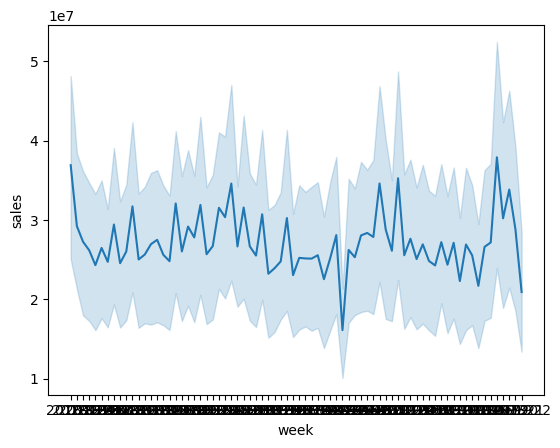

In [133]:
sns.lineplot(weekly_df, x="week", y="sales")

In [134]:
# stationary check
from statsmodels.tsa.stattools import adfuller
result = adfuller(weekly_df['sales'])
print('p-value: %f' % result[1])

p-value: 0.008739


In [141]:
# add lags
how_many_lags = 2
lagged_df = weekly_df.copy()
for t in range(1, how_many_lags + 1):
    lagged_df[f'sales-{t}'] = lagged_df['sales'].shift(t)
print(lagged_df.shape)
lagged_df.head()

(296, 10)


,year,weekofyear,region_code,sales,orders,discounts,holidays,week,sales-1,sales-2
0,2018,1,R1,52925573.22,73891,0.679435,0.125000,2018-1,NaN,NaN
1,2018,1,R2,41212947.18,53120,0.697619,0.125000,2018-1,52925573.22,NaN
2,2018,1,R3,33846983.79,42500,0.662791,0.125000,2018-1,41212947.18,52925573.22
3,2018,1,R4,19725848.31,24119,0.665000,0.125000,2018-1,33846983.79,41212947.18
4,2018,2,R1,42225337.95,62244,0.283410,0.142857,2018-2,19725848.31,33846983.79


In [147]:
# Dummify the region code feature
dummy = pd.get_dummies(lagged_df[['region_code']], drop_first=True)
lagged_df = pd.concat([lagged_df, dummy], axis=1)
lagged_df.head()

,year,weekofyear,region_code,sales,orders,discounts,holidays,week,sales-1,sales-2,region_code_R2,region_code_R3,region_code_R4
6,2018,2,R3,27010367.64,35207,0.282392,0.142857,2018-2,32069488.47,42225337.95,0,1,0
7,2018,2,R4,15658937.31,19661,0.291429,0.142857,2018-2,27010367.64,32069488.47,0,0,1
8,2018,3,R1,39719301.00,67505,0.430876,0.000000,2018-3,15658937.31,27010367.64,0,0,0
9,2018,3,R2,29845125.00,46585,0.431293,0.000000,2018-3,39719301.00,15658937.31,1,0,0
10,2018,3,R3,25497876.00,38246,0.431894,0.000000,2018-3,29845125.00,39719301.00,0,1,0


In [148]:
# Instantiate the model
lagged_df = lagged_df.iloc[how_many_lags:, :]
features = [f"sales-{t}" for t in range(1, how_many_lags + 1)] + \
    ["holidays", "discounts"] + \
    [f"region_code_R{r}" for  r in range(2,5)]

lr = LinearRegression()
lr.fit(X=lagged_df[features], y=lagged_df['sales'])
print(list(zip(lr.feature_names_in_, lr.coef_)))
print(lr.intercept_)

['sales-1', 'sales-2', 'holidays', 'discounts', 'region_code_R2', 'region_code_R3', 'region_code_R4']
[('sales-1', 0.4049763057608632), ('sales-2', 0.08931380220137417), ('holidays', -6152870.973162895), ('discounts', 5305212.157478567), ('region_code_R2', -20778081.084106147), ('region_code_R3', -22648354.881627545), ('region_code_R4', -31407860.366175476)]
30827296.736496024


In [154]:
#Sales prediction for the each region
pred_week = lagged_df.iloc[-4:,:][features].to_numpy()
pred_sales = lr.predict(pred_week)
print(pred_sales)

[40489513.5400174  25931120.40919068 21672182.32667304 10434388.26120698]


/Users/ella/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [151]:
lagged_df.tail()

,year,weekofyear,region_code,sales,orders,discounts,holidays,week,sales-1,sales-2,region_code_R2,region_code_R3,region_code_R4
291,2019,21,R4,14438613.00,20193,0.374286,0.0,2019-21,26504508.00,30914343.00,0,0,1
292,2019,22,R1,31535552.10,49918,0.504839,0.2,2019-22,14438613.00,26504508.00,0,0,0
293,2019,22,R2,22791390.48,33249,0.575238,0.2,2019-22,31535552.10,14438613.00,1,0,0
294,2019,22,R3,19132778.37,27089,0.504651,0.2,2019-22,22791390.48,31535552.10,0,1,0
295,2019,22,R4,10286828.04,14342,0.464000,0.2,2019-22,19132778.37,22791390.48,0,0,1
